Purpose: Cox model with SBP and DBP in relation to all cause death  
Programmer:Hillary Mulder  
Date:August 2019  

Modification:  


In [17]:
library(survival)
library(dplyr)
library(tidyr)
library(lattice)
library(splines)

hyp=read.csv("/mnt/workspace/DCRI/Data/analysis_ds_clusters.csv")
hyp$cluster1=factor(hyp$cluster1, levels=1:4)
hyp$cluster2=factor(hyp$cluster2, levels=1:5)

#pulse pressure computation
hyp$pp = hyp$BP.s - hyp$BP.d

train=hyp[which(hyp$train==1),]
test=hyp[which(hyp$test==1),]

colnames(hyp)

hyp %>%
    select(study.1, BP.s, BP.d, dthDays) %>%
    group_by(study.1) %>%
    summarise(days_mean = mean(dthDays, na.rm=T), days_median = median(dthDays, na.rm=T), min_days=min(dthDays, na.rm=T), max_days=max(dthDays, na.rm=T))

#make the matrix a bit smaller
for_cox=hyp[, c('person_id','BP.s','BP.d', 'type_hyp','death','tdeath', 'study.1','cluster1','cluster2','train','test')]


train2=for_cox[which(for_cox$train==1),]
test2=for_cox[which(for_cox$test==1),]

[1] "person_id"  "age"        "Sex"        "Race"       "Race2"     
 [6] "BMI"        "weight"     "height"     "Toba"       "Htn"       
[11] "HxDM"       "HxMIStr"    "revasc"     "BP.s"       "BP.d"      
[16] "LDL"        "HDL"        "TChol"      "Trig"       "HMG"       
[21] "asprin"     "antihyp"    "MI"         "HxStr"      "CABG"      
[26] "PCI"        "Loop"       "thiazide"   "KDiur"      "ARB"       
[31] "AceI"       "Dihy"       "nonDihy"    "BetaB"      "rese"      
[36] "othBPmed"   "ONitra"     "nslNitrate" "TZD"        "VASO"      
[41] "Cent"       "AlphaB"     "K"          "dthDays"    "dthStat"   
[46] "study.x"    "studyIDI"   "DIUR"       "CaCB"       "study.1"   
[51] "type_hyp"   "death"      "tdeath"     "train"      "test"      
[56] "study.y"    "cluster1"   "cluster2"   "pp"

study.1,days_mean,days_median,min_days,max_days
ACCORD,1795.318,1818.711,0.04166666,2556.75
AIMHIGH,1215.670,1229.000,0.00000000,1985.00
ALLHAT,1188.524,1157.500,0.00000000,2177.00
BARI2D,1802.079,1828.000,1.00000000,2840.00


study.1,days_mean,days_median,min_days,max_days
ACCORD,1795.318,1818.711,0.04166666,2556.75
AIMHIGH,1215.670,1229.000,0.00000000,1985.00
ALLHAT,1188.524,1157.500,0.00000000,2177.00
BARI2D,1802.079,1828.000,1.00000000,2840.00


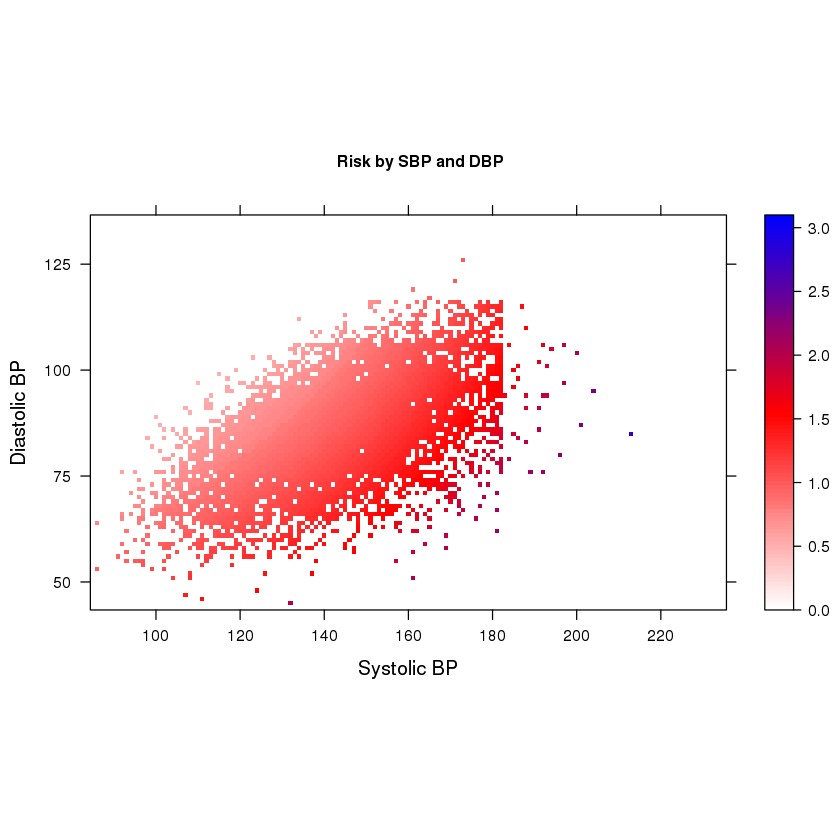

In [4]:
cox1=coxph(Surv(tdeath, death)~BP.s + BP.d + BP.s*BP.d, data=train)
predictions = predict(cox1, test, type='risk')
#to do: split into train/test (75/25) sets using stratified random sampling with trials as stratification variable
#cov=test[,c('BP.s','BP.d')]
#s2 = predictProb.coxph(cox1, Surv(test$tdeath, test$death), cov, times=365 )
#full=cbind(test, s2)
#full$failure=1-full$s2

hm = data.frame(x=test$BP.s, y=test$BP.d, z=predictions)
hm2 = hm %>%
    group_by(x, y) %>%
    summarize(mean_risk = mean(z, na.rm=T))

x=seq(83, 234, 1)
y=seq(42, 129, 1)
fake = data.frame(merge(x, y, all=T), mean_risk=NA)
hm2=rbind(data.frame(hm2), fake)
hm_final = hm2 %>%
         group_by(x, y) %>%
         summarize(risk = mean(mean_risk, na.rm=T))

hm.wide = hm_final %>% spread(x, risk)
hm_mat=as.matrix(hm.wide[, 2:152])

row.names(hm_mat) = t(hm.wide[,1])
palette <- colorRampPalette(c("white", "red", "blue"))( 100 )
my.at.1 <- seq(0, 3.1, length.out=99)


p0=levelplot(t(hm_mat), at=my.at.1,
             col.regions=palette, xlab='Systolic BP', cex.lab=0.8,
             ylab='Diastolic BP', main=list("Risk by SBP and DBP", cex=0.8),
              scales=list(x=list(at=c(16, 36, 56, 76, 96, 116, 136), labels=c('100', '120', '140', '160', '180', '200', '220')),
              y=list(at=c(7, 32, 57, 82), labels=c('50', '75', '100', '125'))))

p0


In [20]:
cox1b=coxph(Surv(tdeath, death)~BP.s + BP.d + BP.s*BP.d + age +Sex + Race2 +HxMIStr+HxDM+study.1, data=train)
summary(cox1b)

Call:
coxph(formula = Surv(tdeath, death) ~ BP.s + BP.d + BP.s * BP.d + 
    age + Sex + Race2 + HxMIStr + HxDM + study.1, data = train)

  n= 29826, number of events= 2324 
   (688 observations deleted due to missingness)

                     coef  exp(coef)   se(coef)      z Pr(>|z|)    
BP.s           -1.259e-02  9.875e-01  7.179e-03 -1.754 0.079452 .  
BP.d           -4.362e-02  9.573e-01  1.339e-02 -3.258 0.001123 ** 
age             6.184e-02  1.064e+00  2.843e-03 21.750  < 2e-16 ***
Sex            -3.576e-01  6.994e-01  4.498e-02 -7.950 1.89e-15 ***
Race2           1.560e-01  1.169e+00  4.626e-02  3.372 0.000745 ***
HxMIStr         3.695e-01  1.447e+00  4.484e-02  8.242 2.22e-16 ***
HxDM            3.365e-01  1.400e+00  4.951e-02  6.797 1.07e-11 ***
study.1AIMHIGH  3.061e-01  1.358e+00  1.044e-01  2.933 0.003356 ** 
study.1ALLHAT   8.127e-01  2.254e+00  6.722e-02 12.089  < 2e-16 ***
study.1BARI2D   5.749e-01  1.777e+00  8.924e-02  6.442 1.18e-10 ***
BP.s:BP.d       2.384e-04  1

In [21]:

cox2=coxph(Surv(tdeath, death)~pp, data=train)
cox2b=coxph(Surv(tdeath, death)~pp+ age +Sex + Race2 +HxMIStr+HxDM+study.1, data=train)
summary(cox2)
summary(cox2b)

Call:
coxph(formula = Surv(tdeath, death) ~ pp, data = train)

  n= 29827, number of events= 2324 
   (687 observations deleted due to missingness)

       coef exp(coef) se(coef)    z Pr(>|z|)    
pp 0.014689  1.014798 0.001347 10.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

   exp(coef) exp(-coef) lower .95 upper .95
pp     1.015     0.9854     1.012     1.017

Concordance= 0.562  (se = 0.006 )
Rsquare= 0.004   (max possible= 0.789 )
Likelihood ratio test= 115.2  on 1 df,   p=0
Wald test            = 118.9  on 1 df,   p=0
Score (logrank) test = 118.8  on 1 df,   p=0


Call:
coxph(formula = Surv(tdeath, death) ~ pp + age + Sex + Race2 + 
    HxMIStr + HxDM + study.1, data = train)

  n= 29826, number of events= 2324 
   (688 observations deleted due to missingness)

                    coef exp(coef)  se(coef)      z Pr(>|z|)    
pp              0.006224  1.006243  0.001444  4.311 1.62e-05 ***
age             0.062716  1.064724  0.002793 22.458  < 2e-16 ***
Sex            -0.357826  0.699195  0.044977 -7.956 1.78e-15 ***
Race2           0.151386  1.163446  0.046101  3.284  0.00102 ** 
HxMIStr         0.373740  1.453160  0.044808  8.341  < 2e-16 ***
HxDM            0.340540  1.405706  0.049341  6.902 5.14e-12 ***
study.1AIMHIGH  0.312347  1.366629  0.104368  2.993  0.00276 ** 
study.1ALLHAT   0.773652  2.167667  0.064427 12.008  < 2e-16 ***
study.1BARI2D   0.594721  1.812525  0.088952  6.686 2.30e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

               exp(coef) exp(-coef) lower .95 upper .95
pp                1.0062 

In [22]:
cox3=coxph(Surv(tdeath, death)~type_hyp, data=train)
cox3b=coxph(Surv(tdeath, death)~type_hyp+ age +Sex + Race2 +HxMIStr+HxDM+study.1, data=train)
summary(cox3)
summary(cox3b)

Call:
coxph(formula = Surv(tdeath, death) ~ type_hyp, data = train)

  n= 29827, number of events= 2324 
   (687 observations deleted due to missingness)

                       coef exp(coef) se(coef)      z Pr(>|z|)   
type_hypControlled -0.18724   0.82924  0.05817 -3.219  0.00129 **
type_hypDiastiolic -0.27202   0.76184  0.10785 -2.522  0.01166 * 
type_hypSystolic    0.07538   1.07830  0.04836  1.559  0.11905   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
type_hypControlled    0.8292     1.2059    0.7399    0.9294
type_hypDiastiolic    0.7618     1.3126    0.6167    0.9412
type_hypSystolic      1.0783     0.9274    0.9808    1.1855

Concordance= 0.525  (se = 0.006 )
Rsquare= 0.001   (max possible= 0.789 )
Likelihood ratio test= 24.75  on 3 df,   p=1.742e-05
Wald test            = 23.85  on 3 df,   p=2.681e-05
Score (logrank) test = 23.98  on 3 df,   p=2.527e-05


Call:
coxph(formula = Surv(tdeath, death) ~ type_hyp + age + Sex + 
    Race2 + HxMIStr + HxDM + study.1, data = train)

  n= 29826, number of events= 2324 
   (688 observations deleted due to missingness)

                       coef exp(coef) se(coef)      z Pr(>|z|)    
type_hypControlled  0.01833   1.01850  0.06286  0.292  0.77062    
type_hypDiastiolic -0.05289   0.94849  0.10849 -0.487  0.62591    
type_hypSystolic    0.05154   1.05289  0.05083  1.014  0.31058    
age                 0.06517   1.06735  0.00275 23.697  < 2e-16 ***
Sex                -0.34663   0.70707  0.04492 -7.717 1.19e-14 ***
Race2               0.14715   1.15853  0.04618  3.186  0.00144 ** 
HxMIStr             0.37143   1.44980  0.04485  8.282  < 2e-16 ***
HxDM                0.34984   1.41884  0.04937  7.087 1.38e-12 ***
study.1AIMHIGH      0.27511   1.31667  0.10443  2.634  0.00843 ** 
study.1ALLHAT       0.78037   2.18227  0.06654 11.727  < 2e-16 ***
study.1BARI2D       0.57332   1.77415  0.08918  6.429 1.

In [24]:
cox4=coxph(Surv(tdeath, death)~cluster1, data=train)
cox4b=coxph(Surv(tdeath, death)~cluster1+ age +Sex + Race2 +HxMIStr+HxDM+study.1, data=train)
summary(cox4)
summary(cox4b)

Call:
coxph(formula = Surv(tdeath, death) ~ cluster1, data = train)

  n= 24063, number of events= 1826 
   (6451 observations deleted due to missingness)

               coef exp(coef)  se(coef)      z Pr(>|z|)    
cluster12 -0.294506  0.744899  0.097687 -3.015  0.00257 ** 
cluster13 -0.326178  0.721676  0.065589 -4.973 6.59e-07 ***
cluster14 -0.006193  0.993826  0.060721 -0.102  0.91876    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
cluster12    0.7449      1.342    0.6151    0.9021
cluster13    0.7217      1.386    0.6346    0.8207
cluster14    0.9938      1.006    0.8823    1.1194

Concordance= 0.539  (se = 0.007 )
Rsquare= 0.002   (max possible= 0.774 )
Likelihood ratio test= 42.81  on 3 df,   p=2.695e-09
Wald test            = 41.7  on 3 df,   p=4.65e-09
Score (logrank) test = 42.04  on 3 df,   p=3.929e-09


Call:
coxph(formula = Surv(tdeath, death) ~ cluster1 + age + Sex + 
    Race2 + HxMIStr + HxDM + study.1, data = train)

  n= 24063, number of events= 1826 
   (6451 observations deleted due to missingness)

                    coef exp(coef)  se(coef)      z Pr(>|z|)    
cluster12       0.030871  1.031353  0.126375  0.244    0.807    
cluster13       0.038029  1.038761  0.129142  0.294    0.768    
cluster14       0.085275  1.089016  0.126672  0.673    0.501    
age             0.068535  1.070938  0.003082 22.235  < 2e-16 ***
Sex            -0.340057  0.711730  0.051707 -6.577 4.81e-11 ***
Race2           0.161254  1.174984  0.111603  1.445    0.148    
HxMIStr         0.415298  1.514822  0.050863  8.165 3.33e-16 ***
HxDM            0.390672  1.477974  0.057622  6.780 1.20e-11 ***
study.1AIMHIGH  0.277008  1.319177  0.110269  2.512    0.012 *  
study.1ALLHAT   0.743512  2.103309  0.080269  9.263  < 2e-16 ***
study.1BARI2D   0.527945  1.695445  0.096901  5.448 5.08e-08 ***
---
Signif. 

In [25]:
cox5=coxph(Surv(tdeath, death)~cluster2, data=train)
cox5b=coxph(Surv(tdeath, death)~cluster2+ age +Sex + Race2 +HxMIStr+HxDM+study.1, data=train)
summary(cox5)
summary(cox5b)

Call:
coxph(formula = Surv(tdeath, death) ~ cluster2, data = train)

  n= 24063, number of events= 1826 
   (6451 observations deleted due to missingness)

             coef exp(coef) se(coef)     z Pr(>|z|)    
cluster22 0.18530   1.20358  0.07987 2.320   0.0203 *  
cluster23 0.10847   1.11457  0.10117 1.072   0.2836    
cluster24 0.42552   1.53039  0.07361 5.780 7.45e-09 ***
cluster25 0.47042   1.60067  0.06655 7.069 1.56e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
cluster22     1.204     0.8309    1.0292     1.408
cluster23     1.115     0.8972    0.9141     1.359
cluster24     1.530     0.6534    1.3248     1.768
cluster25     1.601     0.6247    1.4049     1.824

Concordance= 0.553  (se = 0.007 )
Rsquare= 0.003   (max possible= 0.774 )
Likelihood ratio test= 66.76  on 4 df,   p=1.097e-13
Wald test            = 64.92  on 4 df,   p=2.671e-13
Score (logrank) test = 65.79  on 4 df,   p=1.755e-13


Call:
coxph(formula = Surv(tdeath, death) ~ cluster2 + age + Sex + 
    Race2 + HxMIStr + HxDM + study.1, data = train)

  n= 24063, number of events= 1826 
   (6451 observations deleted due to missingness)

                    coef exp(coef)  se(coef)      z Pr(>|z|)    
cluster22      -0.050045  0.951187  0.088823 -0.563   0.5731    
cluster23      -0.090301  0.913656  0.109848 -0.822   0.4110    
cluster24      -0.146064  0.864103  0.120203 -1.215   0.2243    
cluster25      -0.028838  0.971574  0.088342 -0.326   0.7441    
age             0.068544  1.070948  0.003085 22.221  < 2e-16 ***
Sex            -0.334357  0.715798  0.051788 -6.456 1.07e-10 ***
Race2           0.184533  1.202657  0.098643  1.871   0.0614 .  
HxMIStr         0.415027  1.514411  0.051543  8.052 7.77e-16 ***
HxDM            0.389897  1.476829  0.057627  6.766 1.32e-11 ***
study.1AIMHIGH  0.281515  1.325136  0.114242  2.464   0.0137 *  
study.1ALLHAT   0.781325  2.184365  0.082431  9.479  < 2e-16 ***
study.1BARI2